In [ ]:
!pip install transformers
!pip install datasets 
!pip install pandas
!pip install evaluate 
!pip install accelerate
!pip install numpy
!pip install sklearn
!pip install openpyxl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import transformers
import datasets
import pandas as pd
import evaluate
import accelerate
import numpy as np
import sklearn
import openpyxl

from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
from transformers import BertTokenizer, BertForMaskedLM, AutoTokenizer, AutoModel, BertForSequenceClassification, AutoModelForSequenceClassification
from transformers import InputExample, InputFeatures, DataCollatorWithPadding

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from transformers import AdamW
from transformers import get_scheduler
from accelerate import Accelerator
from tqdm.auto import tqdm
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
import torch.nn.init as init
from torch import argmax
from torch import no_grad, tensor


In [ ]:
#importing training and test sets
train=pd.read_json('train.jsonl', lines=True)
test=pd.read_json('test.jsonl', lines=True)

train_final = datasets.Dataset.from_dict(train)
val_final = datasets.Dataset.from_dict(test)

dataset_dict = datasets.DatasetDict({"train":train_final,"test":val_final, })

In [ ]:
#defining the two model names
distil_roberta = "distilroberta-base" #this on is case sensitive
climatebert = "climatebert/distilroberta-base-climate-f"

#choosing the specific model
model_name = distil_roberta #climatebert 
labels = 2

#downloading tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = labels) # problem_type="multi_label_classification")

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weig

In [ ]:
#tokenizing the data
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length = 512,padding='max_length')

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

batch_size = 32

#preparing data via dataloader
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)

In [ ]:
# setting up lists for handling loss/accuracy
train_accuracies, eval_accuracies = [],[]
train_losses, eval_losses = [],[]

train_targs, train_preds = [], []
eval_targs, eval_preds = [],[]

f1_eval_all, f1_train_all  = [], []

### Initializing model and optimizer
accelerator = Accelerator()
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
optimizer = AdamW(model.parameters(), 
                lr=5e-5, weight_decay=0.01)

### Preparing training and evaluation datasets 
train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

# Setting the scheduler
num_epochs = 100
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


#defining the class weight
weights = [1, 2]
class_weights = torch.FloatTensor(weights).cuda()

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 

In [ ]:
directory = '/content/drive/MyDrive/DL_classification_distil'   #change to own directory

In [ ]:
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    
    #----------------### The training loop ####---------------
    model.train()
    cur_train_targs, cur_train_preds = [],[]
    train_loss = 0
    
    for batch in train_dl:
        outputs = model(**batch)
        
        #Predictions
        logits = outputs.logits
        predictions = argmax(logits, dim=-1)
        
        cur_train_targs += batch["labels"].tolist() 
        cur_train_preds += predictions.tolist()    
        
        #Losses
        criterion = nn.CrossEntropyLoss(weight = class_weights)
        loss = criterion(logits, batch["labels"])
        #loss = outputs.loss #old loss

        accelerator.backward(loss)
        train_loss += loss 
        #Optimizer step
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    #----------------### The evaluation loop ####---------------
    model.eval()
    cur_eval_targs, cur_eval_preds = [],[]
    eval_loss = 0
    metric = evaluate.load("glue", "mrpc")

    for batch in eval_dl:
        with no_grad():
            outputs = model(**batch)

        #Predictions
        logits = outputs.logits
        predictions = argmax(logits, dim=-1)
        
        cur_eval_targs += batch["labels"].tolist()      
        cur_eval_preds += predictions.tolist()         
        
        #Losses
        eval_loss += outputs.loss 
        metric.add_batch(predictions=predictions, references=batch["labels"])

    #---- Taking note of the losses and accuracies #--#
    train_losses.append(train_loss.tolist() / len(train_dl))  # the training loss
    eval_losses.append(eval_loss.tolist() / len(eval_dl))    # the validation loss

    train_acc_cur = accuracy_score(cur_train_targs, cur_train_preds)    
    train_accuracies.append(train_acc_cur)
    
    eval_acc_cur = accuracy_score(cur_eval_targs, cur_eval_preds)    
    eval_accuracies.append(eval_acc_cur)
    
    f1_train = f1_score(cur_train_targs, cur_train_preds, average='weighted')
    f1_eval = f1_score(cur_eval_targs, cur_eval_preds, average='weighted')
    f1_train_all.append(f1_train)
    f1_eval_all.append(f1_eval)

    #----------- Keeping track of the actual predictions and targets #---------#
    eval_targs += cur_eval_targs
    eval_preds += cur_eval_preds
      
    train_targs += cur_train_targs
    train_preds += cur_train_preds
    #------------------------------------------------------------------------------#
    pd.DataFrame(eval_targs).to_excel(directory + '/last_eval_targs.xlsx')
    pd.DataFrame(eval_preds).to_excel(directory + '/last_eval_preds.xlsx')
    pd.DataFrame(train_targs).to_excel(directory + '/last_train_targs.xlsx')
    pd.DataFrame(train_preds).to_excel(directory + '/last_train_preds.xlsx')
    pd.DataFrame(train_losses).to_excel(directory + '/train_losses.xlsx')
    pd.DataFrame(eval_losses).to_excel(directory + '/eval_losses.xlsx')
    pd.DataFrame(train_accuracies).to_excel(directory + '/train_accuracies.xlsx')
    pd.DataFrame(eval_accuracies).to_excel(directory + '/eval_accuracies.xlsx')
    pd.DataFrame(f1_train_all).to_excel(directory + '/f1_train_all.xlsx')
    pd.DataFrame(f1_eval_all).to_excel(directory + '/f1_eval_all.xlsx')


  1%|          | 75/7500 [01:44<2:58:07,  1.44s/it]

100%|██████████| 7500/7500 [3:36:50<00:00,  1.44s/it]

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
last_eval_targs = pd.read_excel(directory + '/last_eval_targs.xlsx')
last_eval_preds = pd.read_excel(directory + '/last_eval_preds.xlsx')
last_train_targs = pd.read_excel(directory + '/last_train_targs.xlsx')
last_train_preds= pd.read_excel(directory + '/last_train_preds.xlsx') 

In [ ]:
train_losses = pd.read_excel(directory + '/train_losses.xlsx')
eval_losses= pd.read_excel(directory + '/eval_losses.xlsx')
train_accuracies = pd.read_excel(directory + '/train_accuracies.xlsx')
eval_accuracies = pd.read_excel(directory + '/eval_accuracies.xlsx')
f1_train_all = pd.read_excel(directory + '/f1_train_all.xlsx')
f1_eval_all = pd.read_excel(directory + '/f1_eval_all.xlsx')

In [ ]:
#calculating statistics
avg_loss_train = np.mean(train_losses.iloc[:,-1])
avg_loss_eval = np.mean(eval_losses.iloc[:,-1])

avg_accur_train = np.mean(train_accuracies.iloc[:,-1])
avg_accur_eval = np.mean(eval_accuracies.iloc[:,-1])

avg_f1_train = np.mean(f1_train_all.iloc[:,-1])
avg_f1_eval = np.mean(f1_eval_all.iloc[:,-1])

best_loss_train = np.min(train_losses.iloc[:,-1])
best_loss_eval = np.min(eval_losses.iloc[:,-1])

best_accur_train = np.max(train_accuracies.iloc[:,-1])
best_accur_eval = np.max(eval_accuracies.iloc[:,-1])

best_f1_train = np.max(f1_train_all.iloc[:,-1])
best_f1_eval = np.max(f1_eval_all.iloc[:,-1])

In [ ]:
#saving statistics
with open(directory + '/Resultater_distil.txt','w') as file:
    file.write('avg_loss_train: ' + str(avg_loss_train))
    file.write('\n')
    file.write('avg_loss_eval: ' + str(avg_loss_eval))
    file.write('\n')
    file.write('avg_accur_train: ' + str(avg_accur_train))
    file.write('\n')
    file.write('avg_accur_eval: ' + str(avg_accur_eval))
    file.write('\n')
    file.write('avg_f1_train: ' + str(avg_f1_train))
    file.write('\n')
    file.write('avg_f1_eval: ' + str(avg_f1_eval))
    file.write('\n')
    file.write('best_loss_train: ' + str(best_loss_train))
    file.write('\n')
    file.write('best_loss_eval: ' + str(best_loss_eval))
    file.write('\n')
    file.write('best_accur_train: ' + str(best_accur_train))
    file.write('\n')
    file.write('best_accur_eval: ' + str(best_accur_eval))
    file.write('\n')
    file.write('best_f1_train: ' + str(best_f1_train))
    file.write('\n')
    file.write('best_f1_eval: ' + str(best_f1_eval))

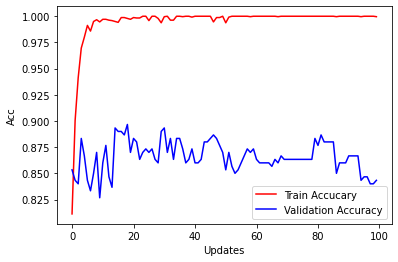

In [ ]:
#plotting accuracies
epoch = np.arange(len(train_accuracies))
fig_scores = plt.figure()
plt.plot(epoch, train_accuracies.iloc[:,-1], 'r', epoch, eval_accuracies.iloc[:,-1], 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
fig_scores.savefig(directory + '/Accuracies_class_distil.png')

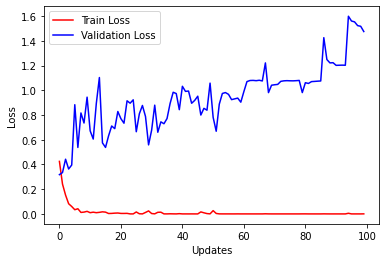

In [ ]:
#plotting losses
epoch = np.arange(len(train_losses))
fig_scores = plt.figure()
plt.plot(epoch, train_losses.iloc[:,-1], 'r', epoch, eval_losses.iloc[:,-1], 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')
fig_scores.savefig(directory + '/Losses_class_distil.png')

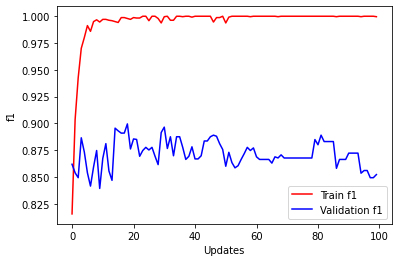

In [ ]:
#plotting f1 scores
epoch = np.arange(len(train_accuracies))
fig_scores = plt.figure()
plt.plot(epoch, f1_train_all.iloc[:,-1], 'r', epoch, f1_eval_all.iloc[:,-1], 'b')
plt.legend(['Train f1','Validation f1'])
plt.xlabel('Updates'), plt.ylabel('f1')
fig_scores.savefig(directory + '/f1_class_distil.png')

In [ ]:
#plotting confusion matrix for the last 500 predictions made 
numpypreds = np.array(last_eval_preds.iloc[-500:,-1])
numpypreds = np.where(numpypreds == 0, 'Non-Climate', np.where(numpypreds == 1, 'Climate-related', 'Else'))

numpylabels = np.array(last_eval_targs.iloc[-500:,-1])
numpylabels = np.where(numpylabels == 0, 'Non-Climate', np.where(numpylabels == 1, 'Climate-related', 'Else'))

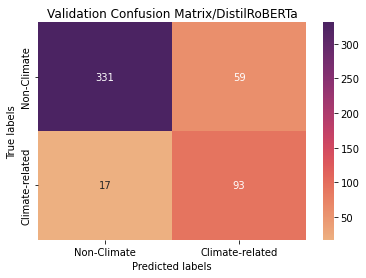

In [ ]:
confmatrix = confusion_matrix(numpylabels, numpypreds, labels = ['Non-Climate','Climate-related'] , sample_weight=None, normalize=None)  
fig = plt.figure()
ax = fig.add_subplot()
sn.heatmap(confmatrix, annot=True, cmap = 'flare',fmt='d', ax=ax, cbar=True);  

# labels, title and ticks
ax.set_xlabel('Predicted labels'); 
ax.set_ylabel('True labels'); 
ax.set_title('Validation Confusion Matrix'+str('/')+'DistilRoBERTa'); 
ax.xaxis.set_ticklabels(['Non-Climate','Climate-related']); ax.yaxis.set_ticklabels(['Non-Climate','Climate-related']);
fig.savefig(directory + '/confmatrix_class_distil.png')
